#### Opgave 1
1. Go to Steam Web Page (dataset link)
2. Type in search 'Dragon Age'
3. Click Search
4. Save a list of all games found with 'Dragon Age' in the game title
5. Print the title of the game that is the oldest

In [134]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys
import bs4
from time import sleep
import datetime
import matplotlib.pyplot as plt
import re

In [135]:
def steam_search(search_term):

    profile = webdriver.FirefoxProfile()
    
    options = Options()
    options.headless = True

    base_url = 'https://store.steampowered.com/search/?category1=998'

    driver = webdriver.Firefox(options=options)

    driver.get('https://store.steampowered.com/search/?category1=998')

    driver.implicitly_wait(3)

    search_input = driver.find_element_by_id('term')

    search_input.send_keys(search_term)

    search_input.send_keys(Keys.RETURN)

    sleep(1)

    return driver.page_source

def convert_date(date_str):
    date_str = date_str.replace(',','')
    if date_str is not None or '':
        return datetime.datetime.strptime(date_str, '%d %b %Y').date()
    else:
        return None



In [136]:
page_source = steam_search('Dragon Age')

soup = bs4.BeautifulSoup(page_source, 'html.parser')
search_results = soup.find_all('div', {'class': 'responsive_search_name_combined'})
games = []

for result in search_results:
    title = result.find('span',{'class':'title'}).getText()
    date = result.find('div', {'class':'search_released'}).getText()
    if 'Dragon Age' in title and date != '':
        games.append((title, convert_date(date)))

games.sort(key=lambda x: x[1])
print(games)

[('Dragon Age: Origins', datetime.date(2009, 11, 6)), ('Dragon Age™: Origins Awakening', datetime.date(2010, 3, 16)), ('Dragon Age™ Inquisition', datetime.date(2020, 6, 4)), ('Dragon Age II', datetime.date(2020, 6, 4))]


#### Opgave 2
1. Go to Steam Web Page (dataset link)
2. Type in search 'Total Annihilation Original'
3. Click Search
4. plot the items in the list into a bar-plot (title as x-labels and price as y-values)
5. find the most expensive game
6. find the oldest game

In [137]:
page_source = steam_search('Total Annihilation Original')

soup = bs4.BeautifulSoup(page_source, 'html.parser')
search_results = soup.find_all('div', {'class': 'responsive_search_name_combined'})

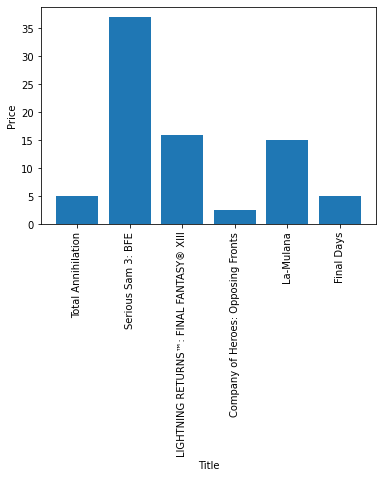

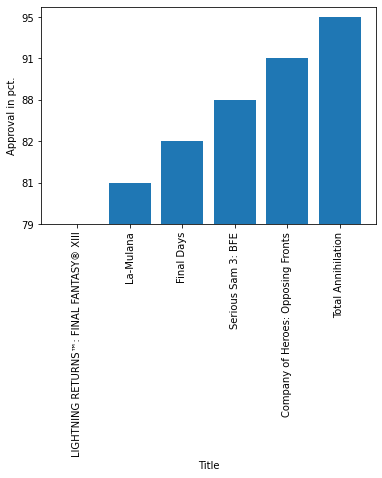

In [138]:
plot_prices(search_results)
plot_approval(search_results)

In [139]:
def clean_price(price):
    price = price.strip()
    price = price.replace('€','')
    price = price.replace(',','.')
    return float(price)

def plot_prices(search_results):
    games = []

    for result in search_results:
        title = result.find('span',{'class':'title'}).getText()
        price = result.find('div', {'class':'search_price'})
        if price.span != None:
            price.span.decompose()

        price = price.getText()

        if price.strip() != '':
            games.append((title, clean_price(price)))

    plt.bar(*zip(*games))
    plt.xticks(rotation=90)
    plt.xlabel('Title')
    plt.ylabel('Price')
    plt.show()

def plot_approval(search_results):
    games = []

    for result in search_results:
        title = result.find('span',{'class':'title'}).getText()
        summary = result.find('span', {'class':'search_review_summary'})
        if summary is not None:
            approval = re.findall(r'\d+', summary['data-tooltip-html'])
            games.append((title, approval[0]))

    games.sort(key=lambda x: x[1], reverse=False)
    plt.bar(*zip(*games))
    plt.xticks(rotation=90)
    plt.xlabel('Title')
    plt.ylabel('Approval in pct.')
    plt.show()


#### Opgave 3
1. Go to Steam Web Page (dataset link)
2. Type in search 'Train Simulator'
3. Click Search
4. Click into the detail page for the first item in the search list (should be Train Simulator 2021)
5. Print the price for the game
6. Print a list of all dlc names and prices
7. Print the dlc title of the most expensive dlc in the list
8. Calculate and Print the price of the base game with all dlcs added

In [140]:
profile = webdriver.FirefoxProfile()
    
options = Options()
options.headless = False

base_url = 'https://store.steampowered.com/search/?category1=998'

driver = webdriver.Firefox(options=options)

driver.get(base_url)

driver.implicitly_wait(3)

search_input = driver.find_element_by_id('term')

search_input.send_keys('Train Simulator')

search_input.send_keys(Keys.RETURN)

sleep(1)

driver.find_element_by_class_name('responsive_search_name_combined').click()

sleep(1)

In [141]:
print_prices_from_details(driver.page_source)
dlcs = get_dlcs_from_details(driver.page_source)
most_expensive_dlc = sorted(dlcs, key=lambda x: x[1], reverse=True)[0]

sum_of_all_dlcs = sum(price for _, price in dlcs)
print(sum_of_all_dlcs)

('Train Simulator 2021', 29.99)
('Train Simulator 2021: Chinese Edition', 39.99)
('Train Simulator 2021 Deluxe', 49.99)
3632.0999999999826


In [142]:
def print_prices_from_details(details_source):
    soup = bs4.BeautifulSoup(details_source, 'html.parser')
    for element in soup.select('div.game_area_purchase_game_wrapper'):
        title = element.h1.text[4:]
        price = element.select_one('div.game_purchase_price').text
        price = clean_price(price)
        print((title, price))

def get_dlcs_from_details(details_source):
    soup = bs4.BeautifulSoup(details_source, 'html.parser')
    dlcs = []
    for element in soup.select('a.game_area_dlc_row'):
        title = element.select_one('.game_area_dlc_name').text.strip()
        price = element.select_one('div.game_area_dlc_price').text.strip()
        price = price[10:] if len(price) > 10 else price
        dlcs.append((title, clean_price(price)))
    return dlcs